# Exploring the Onboard data Ontology using Pandas

In this notebook we will be querying and processing data points from Onboard API to explore them. Make sure to run the following chunk of code first in order to install it.

How to query data points metadata, process them and visually explore them. This notebook is outlined in several YouTube videos that discuss:
- how to [get started exploring building metadata/points](https://www.youtube.com/watch?v=IhY673vR4No),
- [select/merge point lists and export as CSV](https://www.youtube.com/watch?v=9pAlMVB_1Vs)
- [and visualize and explore the point lists](https://youtu.be/rvjbcCggeHI)


Onboard’s data model (the Ontology) contains both equipment types (e.g. fans, air handling units) and point types (e.g. zone temperature sensors). We can query the full data model within the API to get all information detailing how each element is described and all the needed ids.

For this notebook, you need to use the API Key with access to the `general` and `building:read` scopes, and create the client:

In [3]:
!pip install onboard.client
from onboard.client import OnboardClient

try: # for this you can either create a key.py file with one line: api_key = 'your api key here'
    from key import api_key
except ImportError: # or you can just input your api key when you get the prompt
  api_key = input('please enter your api_key')

client = OnboardClient(api_key=api_key)

In [350]:
client.whoami()

{'result': 'ok',
 'apiKeyInHeader': True,
 'apiKeyScopes': ['general',
  'buildings:read',
  'auth',
  'collection:admin',
  'buildings:write',
  'collection'],
 'apiVersion': '2022-04-14',
 'userInfo': {'token': None,
  'name': 'Christopher',
  'full_name': 'Christopher DT',
  'username': 'christopher',
  'palette': {'primary': {'main': ''}, 'secondary': {'main': ''}},
  'org_short_name': 'Onboard',
  'org_id': 2,
  'logo_url': '',
  'mfa_required': True},
 'authLevel': 0}

The Onboard model consists of several classes:

- Equipment
- Points
- Measurements
- Location
- Relationships

In this section we will be focussing on **Equipment** and **Points**.

## Equipment

An equipment type categorizes pieces of equipment with similar properties, often including further sub types nested within them. Let's use the client to inspect how they are defined in the model:

In [4]:
import pandas as pd # we will manipulate and analyze data using Pandas
building_ids = [427, 428] # these are the building IDs for our mock example buildings
buildings = pd.DataFrame(client.get_all_buildings()).query('id in @building_ids') # get only buildings of interest
buildings

# Get the types, which returns a json object
types = client.get_equipment_types()

# Convert it to dataframe
equip_type = pd.json_normalize(types)

# Check it out
equip_type.head()

,id,tag_name,name_long,name_abbr,active,flow_order,critical_point_types,sub_types,tags
0,12,ahu,Air Handling Unit,AHU,True,2,"[79, 85, 103, 159, 160]","[{'id': 1, 'equipment_type_id': 12, 'tag_name'...","[hvac, ahu]"
1,19,boiler,Boiler,BLR,True,1,"[88, 131, 92, 167, 121]","[{'id': 4, 'equipment_type_id': 19, 'tag_name'...","[hvac, boiler]"
2,20,chilledWaterPlant,Chilled Water Plant,CHWS,True,1,"[89, 132, 93, 116, 108]",[],"[hvac, chilledWaterPlant]"
3,21,chiller,Chiller,CH,True,1,"[89, 132, 93, 167, 121]","[{'id': 7, 'equipment_type_id': 21, 'tag_name'...","[hvac, chiller]"
4,22,condenser,Condenser,COND,True,1,[121],[],"[hvac, condenser]"


And we already got a DataFrame! We can use the method `.info()` in order to inspect our [data types](https://pbpython.com/pandas_dtypes.html):

In [5]:
equip_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    39 non-null     int64 
 1   tag_name              39 non-null     object
 2   name_long             39 non-null     object
 3   name_abbr             39 non-null     object
 4   active                39 non-null     bool  
 5   flow_order            39 non-null     int64 
 6   critical_point_types  39 non-null     object
 7   sub_types             39 non-null     object
 8   tags                  39 non-null     object
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ KB


See the column `sub_type`? That's some weird content. That's because each value in that column is a list of dictionaries (which can be converted to a DataFrame). You can select a specific `sub_type`, by `tag_name` for example, and convert it into an individual DataFrame:

In [353]:
# Select
equip_type.loc[equip_type.tag_name == 'fan','sub_types']

7    [{'id': 12, 'equipment_type_id': 26, 'tag_name...
Name: sub_types, dtype: object

Not there yet. We have to use [`.item()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.item.html) to get the first element of that pandas series:

In [6]:
equip_type[equip_type.tag_name == 'fan']['sub_types'].item()

[{'id': 12,
  'equipment_type_id': 26,
  'tag_name': 'exhaustFan',
  'name_long': 'Exhaust Fan',
  'name_abbr': 'EFN'},
 {'id': 13,
  'equipment_type_id': 26,
  'tag_name': 'reliefFan',
  'name_long': 'Relief Fan',
  'name_abbr': 'RlFN'},
 {'id': 14,
  'equipment_type_id': 26,
  'tag_name': 'returnFan',
  'name_long': 'Return Fan',
  'name_abbr': 'RFN'},
 {'id': 15,
  'equipment_type_id': 26,
  'tag_name': 'supplyFan',
  'name_long': 'Supply Fan',
  'name_abbr': 'SFN'},
 {'id': 27,
  'equipment_type_id': 26,
  'tag_name': 'boosterFan',
  'name_long': 'Booster Fan',
  'name_abbr': 'BFN'},
 {'id': 28,
  'equipment_type_id': 26,
  'tag_name': 'coolingTowerFan',
  'name_long': 'Cooling Tower Fan',
  'name_abbr': 'CTFN'}]

We are getting there, here we got the list containing all dictionaries. Let's convert it to a dataframe:

In [7]:
sub_type = pd.DataFrame(equip_type[equip_type.tag_name == 'fan']['sub_types'].item())
sub_type

,id,equipment_type_id,tag_name,name_long,name_abbr
0,12,26,exhaustFan,Exhaust Fan,EFN
1,13,26,reliefFan,Relief Fan,RlFN
2,14,26,returnFan,Return Fan,RFN
3,15,26,supplyFan,Supply Fan,SFN
4,27,26,boosterFan,Booster Fan,BFN
5,28,26,coolingTowerFan,Cooling Tower Fan,CTFN


A dataframe with all the fan subtypes! These were all under the "fan" `tag_name`.

## Data Points

A point type defines a sensor reading on a piece of equipment. As in the previous section, we can inspect them:

In [8]:
# Get all point types from the Data Model
point_type = pd.DataFrame(client.get_all_point_types())
point_type

,id,tag_name,active,measurement_id,tag_set_ids,tags,default_unit_id
0,124,Occupied Heating Setpoint,True,1,"[15, 2, 4, 62, 51, 55]","[air, sp, temp, zone, heating, occ]",None
1,118,Outside Air Carbon Dioxide,True,6,"[15, 8, 1, 24]","[air, co2, sensor, outside]",None
2,130,Return Air Temperature Setpoint,True,1,"[15, 2, 4, 63]","[air, sp, temp, return]",None
3,84,Dual-Temp Coil Discharge Air Temperature,True,1,"[15, 36, 47, 1, 4, 250]","[air, discharge, dualTemp, sensor, temp, coil]",None
4,81,Reheat Coil Discharge Air Temperature,True,1,"[15, 36, 44, 1, 4, 250]","[air, discharge, reheats, sensor, temp, coil]",None
...,...,...,...,...,...,...,...
654,761,Average Zone Temperature,True,1,"[1, 15, 4, 62, 213]","[sensor, air, temp, zone, avg]",None
655,762,Oil Pressure,True,3,"[1, 193, 6]","[sensor, oil, pressure]",None
656,763,Oil Temperature,True,1,"[1, 4, 193]","[sensor, temp, oil]",None
657,764,Runtime Status,True,11,"[19, 1]","[run, sensor]",None


This table is pretty explicit on the descriptions. The only lists inside this dataFrame are in `tag_set_ids` and `tags`. Let's explore them in the following section.

## Haystack Tag Sets

As we saw in the previous table, all points and equipment are tagged using [Haystack Tag Sets](https://project-haystack.org/doc/appendix/tags). Let's list all of them:

In [357]:
# Get all tags and their definitions from the Data Model
pd.DataFrame(client.get_tags())

,id,name,definition,def_source,def_url,category
0,120,battery,A container that stores chemical energy that c...,brick,https://brickschema.org/ontology/1.1/classes/B...,None
1,191,exhaustVAV,A device that regulates the volume of air bein...,onboard,None,None
2,193,oil,"A viscous liquid derived from petroleum, espec...",brick,https://brickschema.org/ontology/1.2/classes/Oil/,None
3,114,fumeHood,A fume-collection device mounted over a work s...,brick,https://brickschema.org/ontology/1.1/classes/F...,None
4,118,limit,A parameter that places a lower or upper bound...,brick,https://brickschema.org/ontology/1.1/classes/L...,Point Class
...,...,...,...,...,...,...
238,12,speed,When used as a vfd point it is speed measured ...,onboard,None,None
239,67,makeup,Points associated with the flow of makeup air;...,onboard,None,None
240,60,max,Associated with a maximum value.,onboard,None,Quantity Modifier
241,61,min,Associated with a minumum value.,onboard,None,Quantity Modifier


Getting the model information is pretty straightforward, you can use it as reference table when you need to know what certain ids or tags means.

# Getting the data from a specific building into a Dataframe

Ok, that was about the model/ontology. But what if we want to query data from an actual building? You will need your API key to have access to the scope building:read. And using the client we can list all the buildings under your organization (using "get_all_...." should work). 

*Note: I appended the `.query()` call below, because otherwise it would show all buildings for all of Onboard's clients, since I'm an admin. You can omit this `.query()` call if you want to see all the buildings in your organization.*

In [358]:
# Get a list of all the buildings under your Organization
pd.json_normalize(client.get_all_buildings()).query('id in @building_ids')

,id,org_id,name,address,sq_ft,image_src,bms_manufacturer,bms_product_name,bms_version,timezone,info,status,equip_count,point_count,info.org,info.cidate,info.floors,info.m2fend,info.satend,info.sunend,info.geoCity,info.sfappno,info.site_id,info.geoCoord,info.geoState,info.m2fstart,info.satstart,info.sunstart,info.rtem_name,info.sfappdate,info.yearBuilt,info.geoCountry,info.weatherRef,info.customerType,info.systemVendor,info.geoPostalCode,info.serviceVendor,info.note
14,428,6,Laboratory,None,NaN,None,None,None,None,America/New_York,NaN,LIVE,122,1654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,427,6,Office Building,None,NaN,None,None,None,None,America/New_York,NaN,LIVE,137,2422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ok, those are a lot of columns! We can transpose the DataFrame to make it more readable, like this:

In [9]:
bdgs = pd.json_normalize(client.get_all_buildings()).query('id in @building_ids')
bdgs.head(10).T

,14,21
id,428,427
org_id,6,6
name,Laboratory,Office Building
address,None,None
sq_ft,NaN,NaN
image_src,None,None
bms_manufacturer,None,None
bms_product_name,None,None
bms_version,None,None
timezone,America/New_York,America/New_York


From this table you can get a summary of each building: location, number of equipments, number of points, sunlight hours and more. This is a good way to get a quick description of the buildings you are working with. Obviously our example buildings here are missing a good deal of building metadata, but for actual buildings this can be a very useful view.

## Querying data points

Maybe the most interesting function of this API is getting data from a specific point (i.e, a sensor). We need to import a specific class for doing this, the *PointSelector*

In [11]:
from onboard.client.models import PointSelector

First create your *PointSelector* object, this will be the query:

In [12]:
query = PointSelector()

And you can specify all the conditions you want ([check the doc](https://onboard-data-python-client-api.readthedocs.io/en/latest/Querying%20Building-Specific%20Data.html#querying-specific-points)). There are multiple ways to select points using the PointSelector. The user can select all the points that are associated with one or more lists containing any of the following:
```
'organizations', 'buildings', 'point_ids', 'point_names', 'point_hashes',
'point_ids', 'point_names', 'point_topics', 'equipment', 'equipment_types'
```
Under these categories you can get the points that meet the conditions you set.

In [13]:
query.point_types = ['Real Power', 'Zone Temperature']
query.buildings = ["427", "428"]

Here we are saying "I want the points of type 'Real Power' and 'Zone Temperature' from buildings 427 and 428". And when you execute that query using `select_points` you will get the points that satisfy those conditions:

In [14]:
selection = client.select_points(query)
selection

{'orgs': [6],
 'buildings': [427, 428],
 'equipment': [27136,
  27137,
  27141,
  27142,
  27143,
  27144,
  27145,
  27146,
  27147,
  27148,
  27149,
  27184,
  27185,
  27189,
  27191,
  27194,
  27206,
  27207,
  27208,
  27209,
  27210,
  27211,
  27212,
  27213,
  33875,
  33876,
  27244,
  27245,
  27246,
  27247,
  27248,
  27267,
  27268,
  27269,
  27270,
  34954,
  34955,
  34956,
  34957,
  27276,
  27278,
  27277,
  27279,
  27307,
  27316,
  27317,
  27324,
  27356,
  27357,
  27364,
  27365,
  27371,
  27372,
  27374,
  27386,
  27397,
  27398,
  27399,
  27400,
  27401,
  27402,
  27403,
  27404,
  27405,
  27406,
  27407,
  27408,
  27409,
  27410,
  27411,
  27412,
  27413,
  27414,
  27415,
  27416,
  27417,
  27418,
  27419,
  27420,
  27421,
  27422,
  27423,
  27424,
  27425,
  27426,
  27427,
  27428,
  27429,
  27430,
  27431,
  27432,
  27433,
  27434,
  27435,
  27436,
  27437,
  27438,
  27439,
  27440,
  27441,
  27442,
  27443,
  27444,
  27445,
  27446,
  

Those are the points, identified by id:

In [65]:
point_ids = selection["points"]
point_ids

[288256,
 291329,
 290822,
 289803,
 290318,
 285719,
 290840,
 289818,
 290846,
 287776,
 291361,
 288291,
 290350,
 285745,
 286258,
 287794,
 291377,
 289333,
 289849,
 290365,
 289345,
 291393,
 287812,
 285766,
 289864,
 286284,
 290892,
 288847,
 286805,
 287830,
 289878,
 288859,
 289886,
 285791,
 290400,
 290910,
 286306,
 289895,
 289910,
 286328,
 290426,
 287355,
 290945,
 284803,
 289926,
 290442,
 287373,
 290960,
 286353,
 284822,
 288407,
 289943,
 290458,
 287391,
 291488,
 285345,
 288424,
 284841,
 291502,
 289968,
 287409,
 286898,
 290995,
 291514,
 284860,
 285889,
 291010,
 287427,
 291522,
 387274,
 387277,
 387281,
 290001,
 287445,
 288982,
 290019,
 287972,
 291046,
 287463,
 289512,
 287481,
 288000,
 290052,
 288009,
 291082,
 285964,
 288526,
 289554,
 290067,
 288532,
 291097,
 288538,
 288544,
 288550,
 289575,
 288556,
 291116,
 289582,
 288562,
 290100,
 289589,
 288568,
 289603,
 290115,
 291139,
 414537,
 386891,
 414539,
 414541,
 414543,
 288079,
 

And getting the points metadata is pretty easy when you have the IDs. You can get all the details about those points using `get_points_by_ids`:

In [66]:
sensor_metadata = client.get_points_by_ids(point_ids)
sensor_metadata = pd.DataFrame(sensor_metadata)
sensor_metadata

,id,building_id,last_updated,first_updated,device,network_device,objectId,name,description,units,tagged_units,raw_unit_id,value,type,point_type_id,measurement_id,datasource_hash,topic,state_text,equip_id
0,386891,427,1.667251e+12,1.643824e+12,None,None,None,zone_temp_1,Zone Temp,degreesFahrenheit,f,2,72.19,Zone Temperature,77,1,e0d05802a283721963acfc03cd916428,onboard/officebldg1/device1003819/analogInput/3,None,27039
1,387274,427,1.667251e+12,1.643824e+12,None,None,None,zone_temp_1,None,degreesFahrenheit,f,2,70.5,Zone Temperature,77,1,9fd2e2f86863916dce8f7c88d3244b18,onboard/officebldg1/device2003136/analogInput/1,None,33875
2,387277,427,1.667251e+12,1.643824e+12,None,None,None,zone_temp_1,None,degreesFahrenheit,f,2,70.5,Zone Temperature,77,1,9ec5376d0d57766e2a3c85a33c855b86,onboard/officebldg1/device2003137/analogInput/1,None,33876
3,387281,427,1.667251e+12,1.643824e+12,None,None,None,dts_temp_1,South Air Temperature,degreesFahrenheit,f,2,61.79,Zone Temperature,77,1,fd91eaf1ce2287abecfd5f151a2e83d4,onboard/officebldg1/device3225/analogInput/10,None,27039
4,414537,428,1.667251e+12,1.647885e+12,Unit 103 MiniCloset_001,None,AI:268,METER #3 THREE-PHASE KW,None,None,kw,17,0.22,Real Power,221,13,652ea9f873b8e588f5530e003231dbd5,onboard/laboratory3/MiniCloset_001/analogInput...,None,34955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,291393,428,1.667251e+12,1.626901e+12,None,None,None,zone_temp_1,Zone Temperature,degreesFahrenheit,f,2,74.0,Zone Temperature,77,1,b89317a04194d80e5de2ccf6fa7260ad,onboard/laboratory1/device28133/analogInput/2,None,27453
157,291488,428,1.667251e+12,1.626901e+12,None,None,None,power_2,None,kilowatts,kw,17,0.0,Real Power,221,13,d4e3b6837964b93a8dc5a45ececf4271,onboard/laboratory1/device28201/analogValue/22,None,27307
158,291502,428,1.667251e+12,1.626901e+12,None,None,None,power_3,None,kilowatts,kw,17,0.0,Real Power,221,13,cd85e6d43d6261906e008c43fa5640f1,onboard/laboratory1/device28201/analogValue/35,None,27364
159,291514,428,1.667251e+12,1.626901e+12,None,None,None,power_4,None,kilowatts,kw,17,7.69,Real Power,221,13,71b8ff70537b6a1b7e32d85b3bda91db,onboard/laboratory1/device28201/analogValue/48,None,27365


What if we want to add information about this equipment to our data? We can get a dataframe with all the equipment (like we did before):

In [19]:
# Get a list of all the equipment in your building
equipment = pd.json_normalize(client.get_all_equipment()).query('building_id in @building_ids')

equipment.head()

,id,building_id,equip_id,suffix,equip_type_name,equip_type_id,equip_type_abbr,equip_type_tag,equip_subtype_name,equip_subtype_id,equip_subtype_tag,flow_order,floor_num_physical,floor_num_served,area_served_desc,equip_dis,parent_equip,child_equip,points,tags
1025,27294,428,exhaustFan-01,1,Fan,26,FAN,fan,Exhaust Fan,12.0,exhaustFan,4,NaN,NaN,Bathrooms,None,[],[],"[{'id': 290783, 'building_id': 428, 'last_upda...","[fan, hvac, exhaustFan]"
1026,27295,428,exhaustFan-021,21,Fan,26,FAN,fan,Exhaust Fan,12.0,exhaustFan,4,1004.0,1004.0,Lab 021,None,[],[],"[{'id': 289684, 'building_id': 428, 'last_upda...","[fan, hvac, exhaustFan]"
1027,27296,428,exhaustFan-022,22,Fan,26,FAN,fan,Exhaust Fan,12.0,exhaustFan,4,1004.0,1004.0,Lab 022,None,[],[],"[{'id': 289653, 'building_id': 428, 'last_upda...","[fan, hvac, exhaustFan]"
1028,27297,428,exhaustFan-115,115,Fan,26,FAN,fan,Exhaust Fan,12.0,exhaustFan,4,1.0,1.0,Lab 115,None,[],[],"[{'id': 290136, 'building_id': 428, 'last_upda...","[fan, hvac, exhaustFan]"
1029,27298,428,exhaustFan-116,116,Fan,26,FAN,fan,Exhaust Fan,12.0,exhaustFan,4,1.0,1.0,Lab 116,None,[],[],"[{'id': 290088, 'building_id': 428, 'last_upda...","[fan, hvac, exhaustFan]"


Don't forget to use the `.info()` method, it's great to know your features and the data types.

In [20]:
equipment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259 entries, 1025 to 1739
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  259 non-null    int64  
 1   building_id         259 non-null    int64  
 2   equip_id            259 non-null    object 
 3   suffix              255 non-null    object 
 4   equip_type_name     259 non-null    object 
 5   equip_type_id       259 non-null    int64  
 6   equip_type_abbr     259 non-null    object 
 7   equip_type_tag      259 non-null    object 
 8   equip_subtype_name  55 non-null     object 
 9   equip_subtype_id    55 non-null     float64
 10  equip_subtype_tag   55 non-null     object 
 11  flow_order          259 non-null    int64  
 12  floor_num_physical  250 non-null    float64
 13  floor_num_served    222 non-null    float64
 14  area_served_desc    258 non-null    object 
 15  equip_dis           0 non-null      object 
 16  pare

We have the `id` for each equipment in the first columns; we also have it in our sensor metadata:

In [368]:
sensor_metadata.head()

,id,building_id,last_updated,first_updated,device,network_device,objectId,name,description,units,tagged_units,raw_unit_id,value,type,point_type_id,measurement_id,datasource_hash,topic,state_text,equip_id
0,386891,427,1.665518e+12,1.643824e+12,None,None,None,zone_temp_1,Zone Temp,degreesFahrenheit,f,2,71.5,Zone Temperature,77,1,e0d05802a283721963acfc03cd916428,onboard/officebldg1/device1003819/analogInput/3,None,27039
1,387274,427,1.665518e+12,1.643824e+12,None,None,None,zone_temp_1,None,degreesFahrenheit,f,2,70.69,Zone Temperature,77,1,9fd2e2f86863916dce8f7c88d3244b18,onboard/officebldg1/device2003136/analogInput/1,None,33875
2,387277,427,1.665518e+12,1.643824e+12,None,None,None,zone_temp_1,None,degreesFahrenheit,f,2,70.19,Zone Temperature,77,1,9ec5376d0d57766e2a3c85a33c855b86,onboard/officebldg1/device2003137/analogInput/1,None,33876
3,387281,427,1.665518e+12,1.643824e+12,None,None,None,dts_temp_1,South Air Temperature,degreesFahrenheit,f,2,57.5,Zone Temperature,77,1,fd91eaf1ce2287abecfd5f151a2e83d4,onboard/officebldg1/device3225/analogInput/10,None,27039
4,414537,428,1.665518e+12,1.647885e+12,Unit 103 MiniCloset_001,None,AI:268,METER #3 THREE-PHASE KW,None,None,kw,17,0.29,Real Power,221,13,652ea9f873b8e588f5530e003231dbd5,onboard/laboratory3/MiniCloset_001/analogInput...,None,34955


In [369]:
sensor_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               161 non-null    int64  
 1   building_id      161 non-null    int64  
 2   last_updated     161 non-null    float64
 3   first_updated    161 non-null    float64
 4   device           4 non-null      object 
 5   network_device   0 non-null      object 
 6   objectId         4 non-null      object 
 7   name             161 non-null    object 
 8   description      145 non-null    object 
 9   units            157 non-null    object 
 10  tagged_units     161 non-null    object 
 11  raw_unit_id      161 non-null    int64  
 12  value            161 non-null    object 
 13  type             161 non-null    object 
 14  point_type_id    161 non-null    int64  
 15  measurement_id   161 non-null    int64  
 16  datasource_hash  161 non-null    object 
 17  topic           

For merging two sets of data we can use [pandas merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html). In this case, we want to preserve the `sensor_metadata` rows and get the rows with those equip_ids from `equipment`. Notice that the column in common doesn't have the same name (it's called "equip_id" in the sensor data and "id" in the equipment data. Just to confuse matters, there does happen to be an "equip_id" in the equipment data, but it is a string that just offers more descriptive information on the equipment). So, we have to specify how to merge these two on differently-named columns. Also, there are columns with the same name: in order to not get mixed up, the `merge` function will add suffixes to each (\_x and \_y by default, or you can specify whatever suffixes you want).

In [370]:
merged = pd.merge(sensor_metadata, equipment, how="left", left_on=["building_id","equip_id"], right_on=["building_id","id"])
merged.head()

,id_x,building_id,last_updated,first_updated,device,network_device,objectId,name,description,units,tagged_units,raw_unit_id,value,type,point_type_id,measurement_id,datasource_hash,topic,state_text,equip_id_x,id_y,equip_id_y,suffix,equip_type_name,equip_type_id,equip_type_abbr,equip_type_tag,equip_subtype_name,equip_subtype_id,equip_subtype_tag,flow_order,floor_num_physical,floor_num_served,area_served_desc,equip_dis,parent_equip,child_equip,points,tags
0,386891,427,1.665518e+12,1.643824e+12,None,None,None,zone_temp_1,Zone Temp,degreesFahrenheit,f,2,71.5,Zone Temperature,77,1,e0d05802a283721963acfc03cd916428,onboard/officebldg1/device1003819/analogInput/3,None,27039,27039,ahu-1,1,Air Handling Unit,12,AHU,ahu,None,NaN,None,2,1005.0,1.0,First Floor,None,[],[27165],"[{'id': 288432, 'building_id': 427, 'last_upda...","[ahu, hvac]"
1,387274,427,1.665518e+12,1.643824e+12,None,None,None,zone_temp_1,None,degreesFahrenheit,f,2,70.69,Zone Temperature,77,1,9fd2e2f86863916dce8f7c88d3244b18,onboard/officebldg1/device2003136/analogInput/1,None,33875,33875,ahu-W043A,W043A,Air Handling Unit,12,AHU,ahu,None,NaN,None,2,1000.0,NaN,W017,None,[],[],"[{'id': 387274, 'building_id': 427, 'last_upda...","[ahu, hvac]"
2,387277,427,1.665518e+12,1.643824e+12,None,None,None,zone_temp_1,None,degreesFahrenheit,f,2,70.19,Zone Temperature,77,1,9ec5376d0d57766e2a3c85a33c855b86,onboard/officebldg1/device2003137/analogInput/1,None,33876,33876,ahu-WM014,WM014,Air Handling Unit,12,AHU,ahu,None,NaN,None,2,1000.0,NaN,W017,None,[],[],"[{'id': 387277, 'building_id': 427, 'last_upda...","[ahu, hvac]"
3,387281,427,1.665518e+12,1.643824e+12,None,None,None,dts_temp_1,South Air Temperature,degreesFahrenheit,f,2,57.5,Zone Temperature,77,1,fd91eaf1ce2287abecfd5f151a2e83d4,onboard/officebldg1/device3225/analogInput/10,None,27039,27039,ahu-1,1,Air Handling Unit,12,AHU,ahu,None,NaN,None,2,1005.0,1.0,First Floor,None,[],[27165],"[{'id': 288432, 'building_id': 427, 'last_upda...","[ahu, hvac]"
4,414537,428,1.665518e+12,1.647885e+12,Unit 103 MiniCloset_001,None,AI:268,METER #3 THREE-PHASE KW,None,None,kw,17,0.29,Real Power,221,13,652ea9f873b8e588f5530e003231dbd5,onboard/laboratory3/MiniCloset_001/analogInput...,None,34955,34955,MC-001-3,MC-001-3,Meter,31,METER,meter,Electrical Meter,16.0,elecMeter,5,NaN,1003.0,Whole Building,None,[],[],"[{'id': 414537, 'building_id': 428, 'last_upda...","[meter, elecMeter]"


In [371]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_x                161 non-null    int64  
 1   building_id         161 non-null    int64  
 2   last_updated        161 non-null    float64
 3   first_updated       161 non-null    float64
 4   device              4 non-null      object 
 5   network_device      0 non-null      object 
 6   objectId            4 non-null      object 
 7   name                161 non-null    object 
 8   description         145 non-null    object 
 9   units               157 non-null    object 
 10  tagged_units        161 non-null    object 
 11  raw_unit_id         161 non-null    int64  
 12  value               161 non-null    object 
 13  type                161 non-null    object 
 14  point_type_id       161 non-null    int64  
 15  measurement_id      161 non-null    int64  
 16  datasour

Always, when merging, make sure to identify the column in common and that they have the same data type.

# Data points exploration

## Data pre-processing

Now that we know how to get the data, let's obtain a big data set of points to explore. In contrast to the last section, here we are getting all the available points in our building to explore them.

In [67]:
points = pd.json_normalize(client.get_points_by_ids(point_ids))
points.head()

,id,building_id,last_updated,first_updated,device,network_device,objectId,name,description,units,tagged_units,raw_unit_id,value,type,point_type_id,measurement_id,datasource_hash,topic,state_text,equip_id
0,386891,427,1.667251e+12,1.643824e+12,None,None,None,zone_temp_1,Zone Temp,degreesFahrenheit,f,2,72.19,Zone Temperature,77,1,e0d05802a283721963acfc03cd916428,onboard/officebldg1/device1003819/analogInput/3,None,27039
1,387274,427,1.667251e+12,1.643824e+12,None,None,None,zone_temp_1,None,degreesFahrenheit,f,2,70.5,Zone Temperature,77,1,9fd2e2f86863916dce8f7c88d3244b18,onboard/officebldg1/device2003136/analogInput/1,None,33875
2,387277,427,1.667251e+12,1.643824e+12,None,None,None,zone_temp_1,None,degreesFahrenheit,f,2,70.5,Zone Temperature,77,1,9ec5376d0d57766e2a3c85a33c855b86,onboard/officebldg1/device2003137/analogInput/1,None,33876
3,387281,427,1.667251e+12,1.643824e+12,None,None,None,dts_temp_1,South Air Temperature,degreesFahrenheit,f,2,61.79,Zone Temperature,77,1,fd91eaf1ce2287abecfd5f151a2e83d4,onboard/officebldg1/device3225/analogInput/10,None,27039
4,414537,428,1.667251e+12,1.647885e+12,Unit 103 MiniCloset_001,None,AI:268,METER #3 THREE-PHASE KW,None,None,kw,17,0.22,Real Power,221,13,652ea9f873b8e588f5530e003231dbd5,onboard/laboratory3/MiniCloset_001/analogInput...,None,34955


In [68]:
points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               161 non-null    int64  
 1   building_id      161 non-null    int64  
 2   last_updated     161 non-null    float64
 3   first_updated    161 non-null    float64
 4   device           4 non-null      object 
 5   network_device   0 non-null      object 
 6   objectId         4 non-null      object 
 7   name             161 non-null    object 
 8   description      145 non-null    object 
 9   units            157 non-null    object 
 10  tagged_units     161 non-null    object 
 11  raw_unit_id      161 non-null    int64  
 12  value            161 non-null    object 
 13  type             161 non-null    object 
 14  point_type_id    161 non-null    int64  
 15  measurement_id   161 non-null    int64  
 16  datasource_hash  161 non-null    object 
 17  topic           

And let's merge it with the buildings metadata.

In [69]:
bdgs = pd.json_normalize(client.get_all_buildings()).query('id in @building_ids')
bdgs

,id,org_id,name,address,sq_ft,image_src,bms_manufacturer,bms_product_name,bms_version,timezone,...,info.rtem_name,info.sfappdate,info.yearBuilt,info.geoCountry,info.weatherRef,info.customerType,info.systemVendor,info.geoPostalCode,info.serviceVendor,info.note
14,428,6,Laboratory,None,NaN,None,None,None,None,America/New_York,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,427,6,Office Building,None,NaN,None,None,None,None,America/New_York,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are goint to add the building name to our points data set. You can select the desired columns using double brackets, like this:

In [70]:
bdgs[["id", "name"]]

,id,name
14,428,Laboratory
21,427,Office Building


And to merge, like we just learned, you have to specify HOW you want to merge (we want to keep all the rows on the LEFT here, the `points` rows) and ON which column. We are also adding suffixes in order to correctly identify which one came from which dataset.

In [71]:
points = pd.merge(points, bdgs[["id", "name"]], how="left", left_on="building_id", right_on="id", suffixes=["_point", "_bdg"])
points.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_point         161 non-null    int64  
 1   building_id      161 non-null    int64  
 2   last_updated     161 non-null    float64
 3   first_updated    161 non-null    float64
 4   device           4 non-null      object 
 5   network_device   0 non-null      object 
 6   objectId         4 non-null      object 
 7   name_point       161 non-null    object 
 8   description      145 non-null    object 
 9   units            157 non-null    object 
 10  tagged_units     161 non-null    object 
 11  raw_unit_id      161 non-null    int64  
 12  value            161 non-null    object 
 13  type             161 non-null    object 
 14  point_type_id    161 non-null    int64  
 15  measurement_id   161 non-null    int64  
 16  datasource_hash  161 non-null    object 
 17  topic           

And now let's add some column from the equipment metadata:

In [72]:
equipment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259 entries, 1025 to 1739
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  259 non-null    int64  
 1   building_id         259 non-null    int64  
 2   equip_id            259 non-null    object 
 3   suffix              255 non-null    object 
 4   equip_type_name     259 non-null    object 
 5   equip_type_id       259 non-null    int64  
 6   equip_type_abbr     259 non-null    object 
 7   equip_type_tag      259 non-null    object 
 8   equip_subtype_name  55 non-null     object 
 9   equip_subtype_id    55 non-null     float64
 10  equip_subtype_tag   55 non-null     object 
 11  flow_order          259 non-null    int64  
 12  floor_num_physical  250 non-null    float64
 13  floor_num_served    222 non-null    float64
 14  area_served_desc    258 non-null    object 
 15  equip_dis           0 non-null      object 
 16  pare

Let's inspect these columns a bit by transposing our dataset (like we did at the beginning):

In [73]:
equipment.head(1).T

,1025
id,27294
building_id,428
equip_id,exhaustFan-01
suffix,1
equip_type_name,Fan
equip_type_id,26
equip_type_abbr,FAN
equip_type_tag,fan
equip_subtype_name,Exhaust Fan
equip_subtype_id,12.0


And again, let's merge. Remember: column(s) in common to merge ON, HOW to merge and optional suffixes.

In [74]:
points = pd.merge(points, equipment[["id","equip_type_abbr","equip_type_name", "area_served_desc", "tags"]], how="left", left_on="equip_id", right_on="id")
points.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_point          161 non-null    int64  
 1   building_id       161 non-null    int64  
 2   last_updated      161 non-null    float64
 3   first_updated     161 non-null    float64
 4   device            4 non-null      object 
 5   network_device    0 non-null      object 
 6   objectId          4 non-null      object 
 7   name_point        161 non-null    object 
 8   description       145 non-null    object 
 9   units             157 non-null    object 
 10  tagged_units      161 non-null    object 
 11  raw_unit_id       161 non-null    int64  
 12  value             161 non-null    object 
 13  type              161 non-null    object 
 14  point_type_id     161 non-null    int64  
 15  measurement_id    161 non-null    int64  
 16  datasource_hash   161 non-null    object 
 1

In [75]:
points.head(1).T

,0
id_point,386891
building_id,427
last_updated,1667250750017.0
first_updated,1643824486983.0
device,None
network_device,None
objectId,None
name_point,zone_temp_1
description,Zone Temp
units,degreesFahrenheit


We got a duplicated column ("id" now is the equipment id) that we can [drop](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html):

In [76]:
# Axis=1 means drop columns. Axis=0 means drop rows
points.drop("id", axis=1, inplace=True)

And let's inspect our missing values. If we have a column with near 100% of missing values we are going to drop them too (this is not actually needed, but extra columns will make the dataset heavier and everything slower).

In [77]:
points.isna().sum()*100 / len(points)

id_point              0.000000
building_id           0.000000
last_updated          0.000000
first_updated         0.000000
device               97.515528
network_device      100.000000
objectId             97.515528
name_point            0.000000
description           9.937888
units                 2.484472
tagged_units          0.000000
raw_unit_id           0.000000
value                 0.000000
type                  0.000000
point_type_id         0.000000
measurement_id        0.000000
datasource_hash       0.000000
topic                 0.000000
state_text          100.000000
equip_id              0.000000
id_bdg                0.000000
name_bdg              0.000000
equip_type_abbr       0.000000
equip_type_name       0.000000
area_served_desc      0.621118
tags                  0.000000
dtype: float64

Let's drop those almost empty columns:

In [78]:
# get those columns missing more the 95% of their data
cols_to_drop = (points.isna().sum()*100 / len(points)).loc[lambda x: x > 95].index.to_list()
points.drop(cols_to_drop, axis=1, inplace=True)
points.isna().sum()*100 / len(points)

id_point            0.000000
building_id         0.000000
last_updated        0.000000
first_updated       0.000000
name_point          0.000000
description         9.937888
units               2.484472
tagged_units        0.000000
raw_unit_id         0.000000
value               0.000000
type                0.000000
point_type_id       0.000000
measurement_id      0.000000
datasource_hash     0.000000
topic               0.000000
equip_id            0.000000
id_bdg              0.000000
name_bdg            0.000000
equip_type_abbr     0.000000
equip_type_name     0.000000
area_served_desc    0.621118
tags                0.000000
dtype: float64

In [79]:
points

,id_point,building_id,last_updated,first_updated,name_point,description,units,tagged_units,raw_unit_id,value,...,measurement_id,datasource_hash,topic,equip_id,id_bdg,name_bdg,equip_type_abbr,equip_type_name,area_served_desc,tags
0,386891,427,1.667251e+12,1.643824e+12,zone_temp_1,Zone Temp,degreesFahrenheit,f,2,72.19,...,1,e0d05802a283721963acfc03cd916428,onboard/officebldg1/device1003819/analogInput/3,27039,427,Office Building,AHU,Air Handling Unit,First Floor,"[ahu, hvac]"
1,387274,427,1.667251e+12,1.643824e+12,zone_temp_1,None,degreesFahrenheit,f,2,70.5,...,1,9fd2e2f86863916dce8f7c88d3244b18,onboard/officebldg1/device2003136/analogInput/1,33875,427,Office Building,AHU,Air Handling Unit,W017,"[ahu, hvac]"
2,387277,427,1.667251e+12,1.643824e+12,zone_temp_1,None,degreesFahrenheit,f,2,70.5,...,1,9ec5376d0d57766e2a3c85a33c855b86,onboard/officebldg1/device2003137/analogInput/1,33876,427,Office Building,AHU,Air Handling Unit,W017,"[ahu, hvac]"
3,387281,427,1.667251e+12,1.643824e+12,dts_temp_1,South Air Temperature,degreesFahrenheit,f,2,61.79,...,1,fd91eaf1ce2287abecfd5f151a2e83d4,onboard/officebldg1/device3225/analogInput/10,27039,427,Office Building,AHU,Air Handling Unit,First Floor,"[ahu, hvac]"
4,414537,428,1.667251e+12,1.647885e+12,METER #3 THREE-PHASE KW,None,None,kw,17,0.22,...,13,652ea9f873b8e588f5530e003231dbd5,onboard/laboratory3/MiniCloset_001/analogInput...,34955,428,Laboratory,METER,Meter,Whole Building,"[meter, elecMeter]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,291393,428,1.667251e+12,1.626901e+12,zone_temp_1,Zone Temperature,degreesFahrenheit,f,2,74.0,...,1,b89317a04194d80e5de2ccf6fa7260ad,onboard/laboratory1/device28133/analogInput/2,27453,428,Laboratory,VAV,Variable Air Volume,Corridor Q201,"[vav, hvac]"
157,291488,428,1.667251e+12,1.626901e+12,power_2,None,kilowatts,kw,17,0.0,...,13,d4e3b6837964b93a8dc5a45ececf4271,onboard/laboratory1/device28201/analogValue/22,27307,428,Laboratory,PUMP,Pump,Whole Building,"[pump, hvac, chilledWaterPump]"
158,291502,428,1.667251e+12,1.626901e+12,power_3,None,kilowatts,kw,17,0.0,...,13,cd85e6d43d6261906e008c43fa5640f1,onboard/laboratory1/device28201/analogValue/35,27364,428,Laboratory,PUMP,Pump,Whole Building,"[pump, hvac, hotWaterPump]"
159,291514,428,1.667251e+12,1.626901e+12,power_4,None,kilowatts,kw,17,7.69,...,13,71b8ff70537b6a1b7e32d85b3bda91db,onboard/laboratory1/device28201/analogValue/48,27365,428,Laboratory,PUMP,Pump,Whole Building,"[pump, hvac, hotWaterPump]"


## Data Visualization

Now let's create some visualizations! We are going to use the libraries *matplotlib* and *seaborn*:

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# This is for the visual style, I like "ggplot"
plt.style.use('ggplot')

# set fig size
plt.rcParams["figure.figsize"] = (20,9)

In [160]:
points.head(1).T

,0
id_point,386891
building_id,427
last_updated,1665509983344.0
first_updated,1643824486983.0
name_point,zone_temp_1
description,Zone Temp
units,degreesFahrenheit
tagged_units,f
raw_unit_id,2
value,72.69


The data set we are working with contains the metadata of each point (sensor). There are a lot of good [visualizations available](https://seaborn.pydata.org/tutorial/categorical.html) for that. Here all of our features are categorical, so we will focus mainly on the bar plots.

We can start exploring the number of points by building. We can check how many points and buildings we have first:

In [81]:
print(f"Number of points: {len(points.id_point.unique())}")
print(f"Number of buildings: {len(points.building_id.unique())}")

Number of points: 161
Number of buildings: 2


With only our two example buildings, we can see how many points there are with a simple table of counts:

In [82]:
points.groupby('building_id').count().id_point

building_id
427    76
428    85
Name: id_point, dtype: int64

But in real life, we often have many buildings and many points. We can visualize these at a glance a little easier by making a simple bar chart to see how the points distribute among them (you can choose [the color you want](https://matplotlib.org/3.5.0/gallery/color/named_colors.html)):

Text(0, 0.5, '# points')

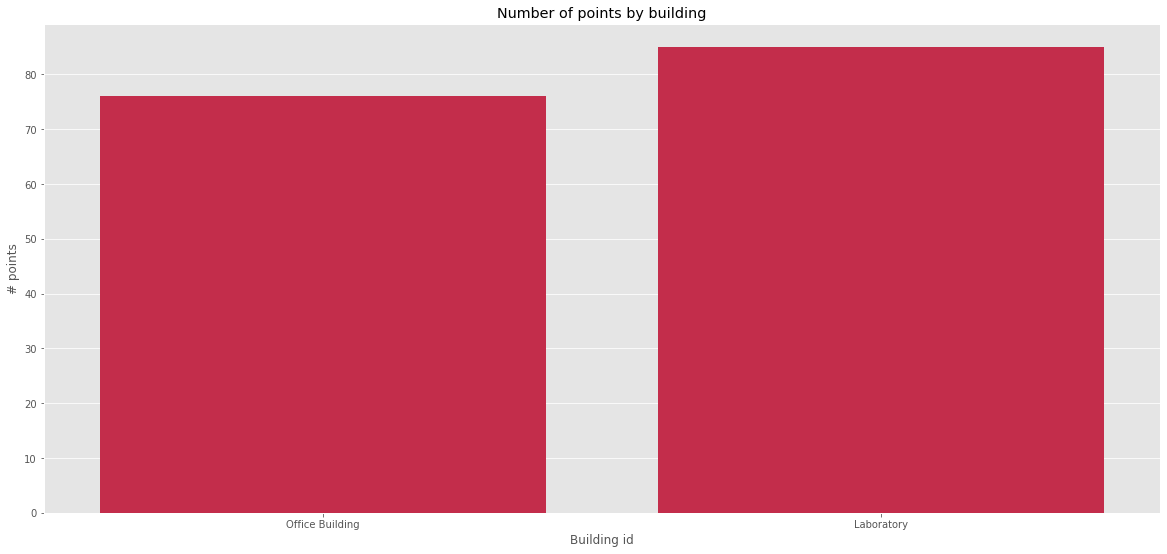

In [94]:
# Number of points by building
fig, ax = plt.subplots(1,1)

# The figure
g0 = sns.countplot(data=points, x="name_bdg", color="crimson", ax=ax)
ax.set_title("Number of points by building")
ax.set_xlabel("Building id")
ax.set_ylabel("# points")

We also have a column named `description` that is -- surprise! -- a description of the sensor, which can give us an idea of the kind of sensors we are working with. Let's try to plot the top 5 descriptions (that is, the most frequent descriptions in our dataset). For that, [we can use the method `value_counts`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html):

In [95]:
points.description.value_counts()

Zone Temperature                            102
Zone Temp                                    37
South Air Temperature                         1
North Air Temperature                         1
Mech Room Space Temp                          1
zone temperature sensor                       1
First Floor F102 Lobby Space Temperature      1
Second Fl F202 Lobby Space Temperature        1
Name: description, dtype: int64

And to filter the top 5 (they are sorted from largest to smallest amount) we just select the first 5 elements and get the `index` (which is the name of the category) so we have a list:

In [96]:
top_five = points.description.value_counts().iloc[:5].index
top_five

Index(['Zone Temperature', 'Zone Temp', 'South Air Temperature',
       'North Air Temperature', 'Mech Room Space Temp'],
      dtype='object')

Let's plot it. We are going to use this list in the parameter `order`, pay attention:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


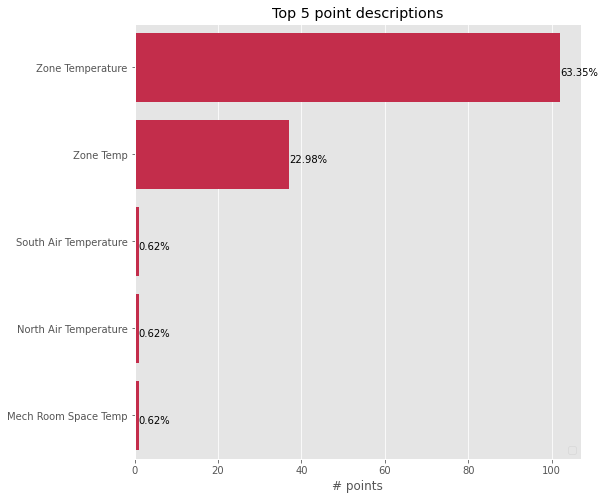

In [97]:
# Top 10 number of points by description

# Let's create a figure with custom size
fig, ax = plt.subplots(1,1, figsize=(8,8))

g1 = sns.countplot(data=points, y="description", order=top_five, ax=ax, color="crimson")
ax.set_title("Top 5 point descriptions")
ax.set_ylabel("")
ax.set_xlabel("# points")
ax.legend(loc="lower right")

## Show percentage at end of the bar
for p in g1.patches:
    txt = str(round(p.get_width() / len(points) * 100, 2)) + '%'
    txt_x = p.get_width() 
    txt_y = p.get_y() + 0.5
    g1.text(txt_x, txt_y, txt)

Now we are going to do something similar but with extra information. We are going to plot the number of points by `equip_type_name` and coloring by `name_bdg`; for the last, we have to use the parameter `hue`:

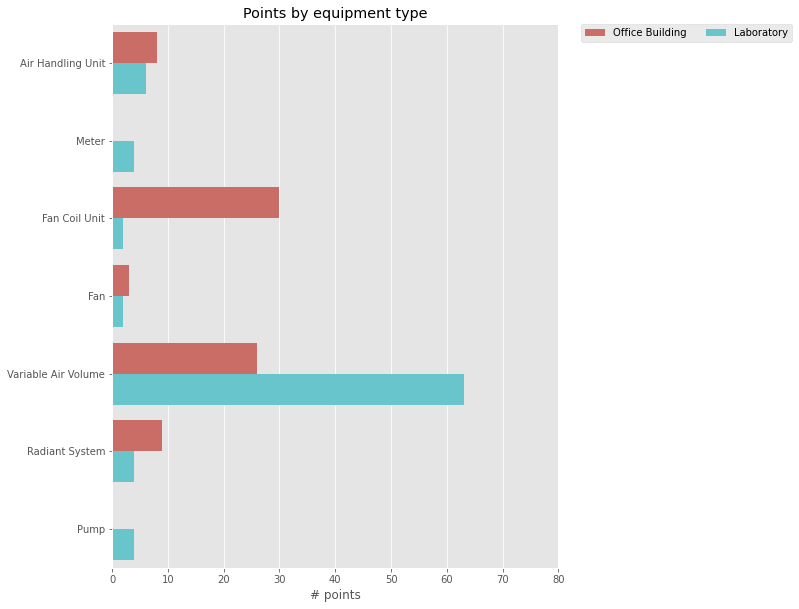

In [207]:
# Number of points by equip type and building

# Let's create a figure with custom size
fig, ax = plt.subplots(1,1, figsize=(8,10))

g2 = sns.countplot(data=points, y="equip_type_name", hue="name_bdg", palette="hls", ax=ax)
ax.set_title("Points by equipment type")
ax.set_ylabel("")
ax.set_xlabel("# points")
ax.set_xlim(0,80)

# Put the legend out of the figure
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)

So, this shows you can visualize more than one feature at the same time.

Finally, let's create a count plot showing how the tags distribute. As you can see in the data, a point can have several tags. Let's find out which ones are the most frequent. We have to get a list with all of them:

In [100]:
# This will create a list with all the tags in our data: it just concatenates the lists from each row
tags = points.tags.sum()

# check the first 10
tags[:10]

['ahu',
 'hvac',
 'ahu',
 'hvac',
 'ahu',
 'hvac',
 'ahu',
 'hvac',
 'meter',
 'elecMeter']

And we have to create a data frame with it:

In [101]:
tags = pd.DataFrame(tags, columns=["tags"])
tags.head()

,tags
0,ahu
1,hvac
2,ahu
3,hvac
4,ahu


A pretty simple data set. Now we can make use of the `countplot` function. We are going to plot the top 20 only (as we did before):

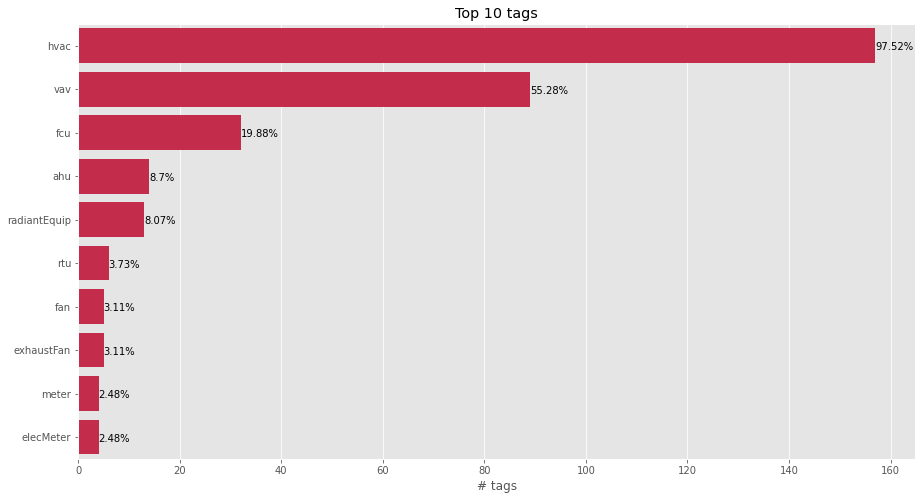

In [102]:
# Top 10 number of tags
ntags = 10

# Let's create a figure with custom size
fig, ax = plt.subplots(1,1, figsize=(15,8))

g4 = sns.countplot(data=tags, y="tags", order=tags.tags.value_counts().iloc[:ntags].index, ax=ax, color="crimson")
ax.set_title(f"Top {ntags} tags")
ax.set_ylabel("")
ax.set_xlabel("# tags")

## Show percentage at end of the bar
for p in g4.patches:
    txt = str(round(p.get_width() / len(points) * 100, 2)) + '%'
    txt_x = p.get_width()
    txt_y = p.get_y() + 0.5
    g4.text(txt_x, txt_y, txt)

Most of the points are hvac. Remember that each point can have several tags, which is why the sum of these percentages is greater than 100.

Now we know how to plot each chart individually, but what if we want only one figure with several subplots? There's a function for that! Just for visualizing, we are going to select only 5 buildings:

In [103]:
bdgs_sel = points.building_id.unique()[:5]
points_sel = points[points.building_id.isin(bdgs_sel)]

The code in this huge block is the same as before, but adapted to this smaller dataset

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


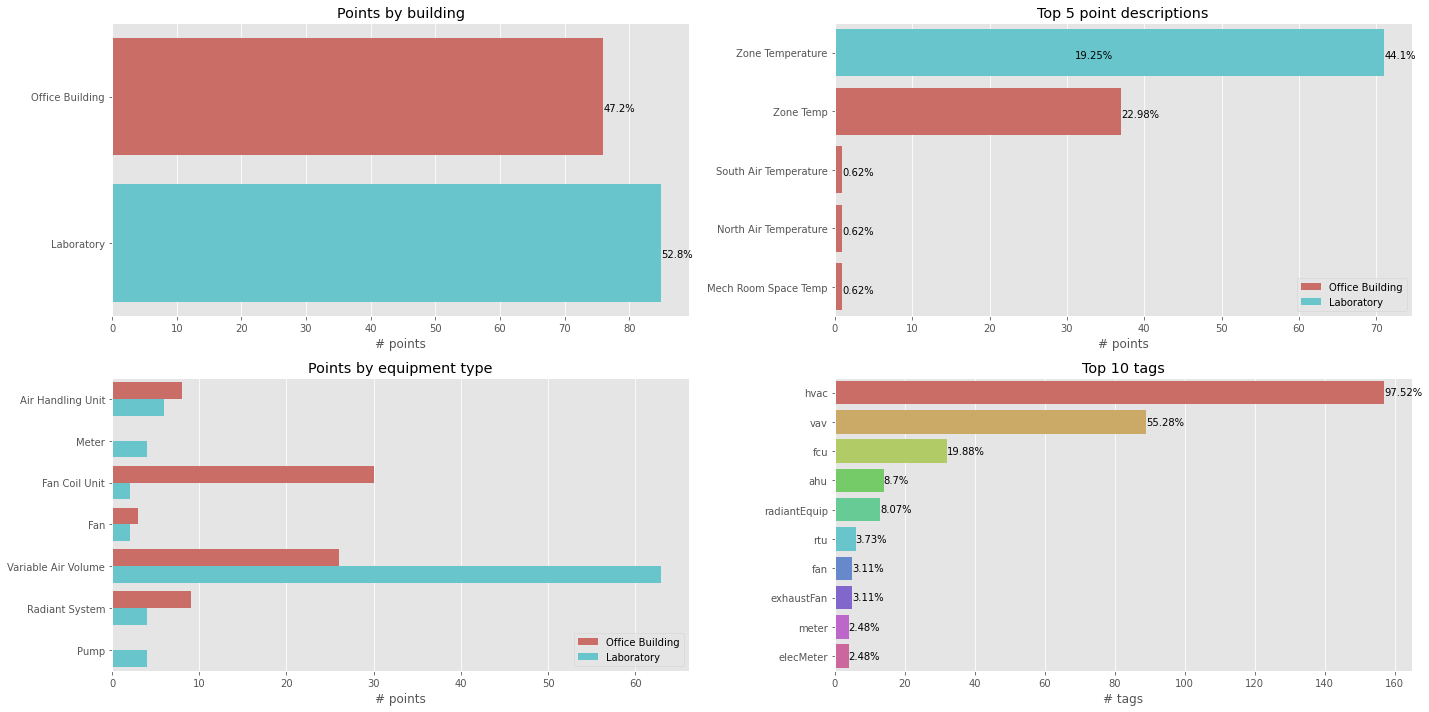

In [104]:
fig, axes = plt.subplots(2,2, figsize=(20,10))
axes = axes.flatten()

# Number of points by building
ax0 = axes[0]
g0 = sns.countplot(data=points_sel, y="name_bdg", ax=ax0, palette="hls")
ax0.set_title("Points by building")
ax0.set_ylabel("")
ax0.set_xlabel("# points")

# used to show percentages at the end of the bar
def format_prctg(subplot):
    for p in subplot.patches:
        txt = str(round(p.get_width() / len(points_sel) * 100, 2)) + '%'
        txt_x = p.get_width()
        txt_y = p.get_y() + 0.5
        subplot.text(txt_x, txt_y, txt)

format_prctg(g0)
    
# Top 10 number of points by description
ax1 = axes[1]
npoints = 5
g1 = sns.countplot(data=points_sel, y="description", order=points_sel.description.value_counts().iloc[:npoints].index, hue="name_bdg", dodge=False, ax=ax1, palette="hls")
ax1.set_title(f"Top {npoints} point descriptions")
ax1.set_ylabel("")
ax1.set_xlabel("# points")
ax1.legend(loc="lower right")
format_prctg(g1)

# Number of points by equip type and building
ax2 = axes[2]
g2 = sns.countplot(data=points_sel, y="equip_type_name", hue="name_bdg", ax=ax2, palette="hls")
ax2.set_title("Points by equipment type")
ax2.set_ylabel("")
ax2.set_xlabel("# points")
ax2.legend(loc="lower right")

# Top 10 number of tags
ax3 = axes[3]
ntags = 10
tags = points_sel.tags.sum()
tags = pd.DataFrame(tags, columns=["tags"])
g3 = sns.countplot(data=tags, y="tags", order=tags.tags.value_counts().iloc[:ntags].index, ax=ax3, palette="hls")
ax3.set_title(f"Top {ntags} tags")
ax3.set_ylabel("")
ax3.set_xlabel("# tags")
format_prctg(g3)

plt.tight_layout()